In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np

import fastsca

import _pnmf,_dcpnmf,_dcpnmfb,_dcpnmfv2,_dcnpnmf
np.random.seed(42)

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
import _topics_util


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
fn

'/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata'

In [2]:
H,W = sca.simdata(N=3000,K=10,P=5000)

<AxesSubplot:>

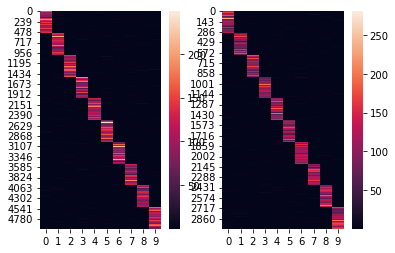

In [3]:
figure,axis = plt.subplots(1,2)
sns.heatmap(W,ax=axis[0])
sns.heatmap(H.T,ax=axis[1])


In [4]:
model = _dcnpnmf.DCNPoissonMF()
model.fit_null(np.asarray(sca.data.mtx))

updating null model....
	After ITERATION: 0	Objective: 135850097179.73	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 135850097179.73	Old objective: 135850097179.73	Improvement: -0.00000




/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcnpnmf.py:56: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


In [5]:
fastsca.run_asapp(sca,save=fn)
fastsca.run_scNMF(sca,fn+'_sc')

updating null model....
	After ITERATION: 0	Objective: 255807342380.99	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 255807342380.99	Old objective: 255807342380.99	Improvement: -0.00000


updating full model....
updating full model....0
updating full model....1
updating full model....2
updating full model....3
updating full model....4
updating full model....5
updating full model....6
updating full model....7
updating full model....8
updating full model....9
updating full model....10
updating full model....11
updating full model....12
updating full model....13
updating full model....14


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:76: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


updating full model....15
updating full model....16
updating full model....17
updating full model....18
updating full model....19
updating full model....20
updating full model....21
updating full model....22
updating full model....23
updating full model....24
generating single cell topic proportion from bulk model....
updating null model....
	After ITERATION: 0	Objective: 135850097179.73	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 135850097179.73	Old objective: 135850097179.73	Improvement: 0.00000


updating bulk to sc model....
updating bulk to sc model....0
updating bulk to sc model....1
updating bulk to sc model....2
updating bulk to sc model....3
updating bulk to sc model....4
updating bulk to sc model....5
updating bulk to sc model....6
updating bulk to sc model....7
updating bulk to sc model....8
updating bulk to sc model....9
updating bulk to sc model....10
updating bulk to sc model....11
updating bulk to sc model....12
updating bulk to sc model....13
upd

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:76: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


	After ITERATION: 1	Objective: 135850097179.73	Old objective: 135850097179.73	Improvement: -0.00000


updating full model....
updating full model....0
updating full model....1
updating full model....2
updating full model....3
updating full model....4
updating full model....5
updating full model....6
updating full model....7
updating full model....8
updating full model....9
updating full model....10
updating full model....11
updating full model....12
updating full model....13
updating full model....14
updating full model....15
updating full model....16
updating full model....17
updating full model....18
updating full model....19
updating full model....20
updating full model....21
updating full model....22
updating full model....23
updating full model....24
updating full model....25
updating full model....26
updating full model....27
updating full model....28
updating full model....29
updating full model....30
updating full model....31
updating full model....32
updating full model....33


In [6]:
df_bd = pd.read_csv(fn+'_depth.csv.gz')
df_bf = pd.read_csv(fn+'_freq.csv.gz')
df_bbeta = pd.read_csv(fn+'_beta.csv.gz')
df_btheta = pd.read_csv(fn+'_theta.csv.gz')

df_scd = pd.read_csv(fn+'_sc_depth.csv.gz')
df_scf = pd.read_csv(fn+'_sc_freq.csv.gz')
df_scbeta = pd.read_csv(fn+'_sc_beta.csv.gz')
df_sctheta = pd.read_csv(fn+'_sc_theta.csv.gz')
df_btheta = df_btheta.rename(columns={'Unnamed: 0':'cell'})
df_bbeta = df_bbeta.rename(columns={'Unnamed: 0':'topic'})
df_sctheta = df_sctheta.rename(columns={'Unnamed: 0':'cell'})
df_scbeta = df_scbeta.rename(columns={'Unnamed: 0':'topic'})

df_bulk_b = pd.read_csv(fn+'_bulk_trace.csv.gz')
df_sc_b = pd.read_csv(fn+'_sc_bulk_trace.csv.gz')
df_scbulk_b = pd.read_csv(fn+'_sc_trace.csv.gz')


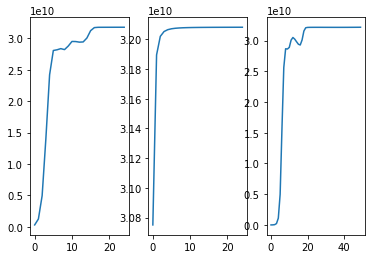

In [7]:
figure,axis = plt.subplots(1,3)
axis[0].plot(df_bulk_b.iloc[:,1].values)
axis[1].plot(df_scbulk_b.iloc[:,1].values)
axis[2].plot(df_sc_b.iloc[:,1].values)

In [8]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = df_sctheta['cell']
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,c_0,9,6,4.660073,-2.147913
1,c_1,9,6,4.622860,-1.645389
2,c_2,9,6,4.640085,-2.099227
3,c_3,9,6,4.631744,-1.438314
4,c_4,9,6,4.960310,-1.463096
...,...,...,...,...,...
2995,c_2995,5,1,-2.862095,17.490742
2996,c_2996,5,1,-3.288964,16.891233
2997,c_2997,5,1,-3.499177,17.684210
2998,c_2998,5,1,-3.046896,17.109089


Text(0, 0.5, 'UMAP2')

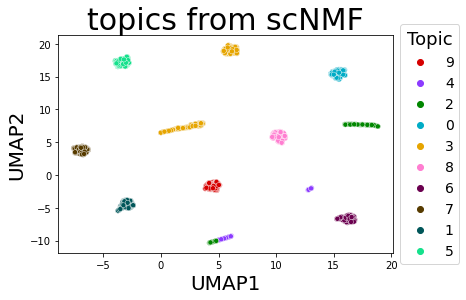

In [12]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

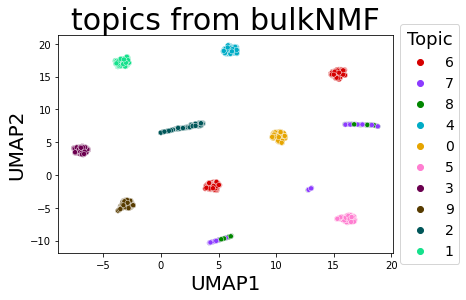

In [11]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

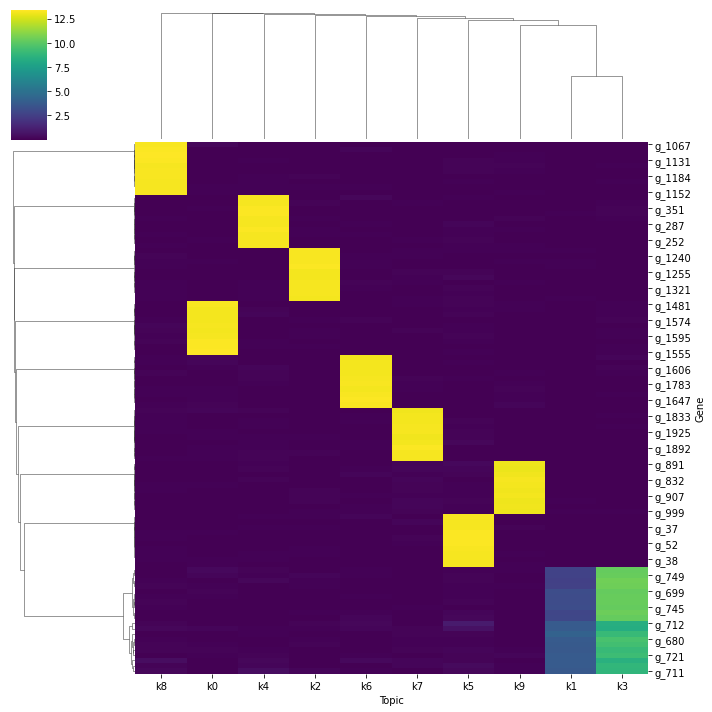

In [53]:
df_top = _topics_util.get_topic_top_genes(df_scbeta,top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

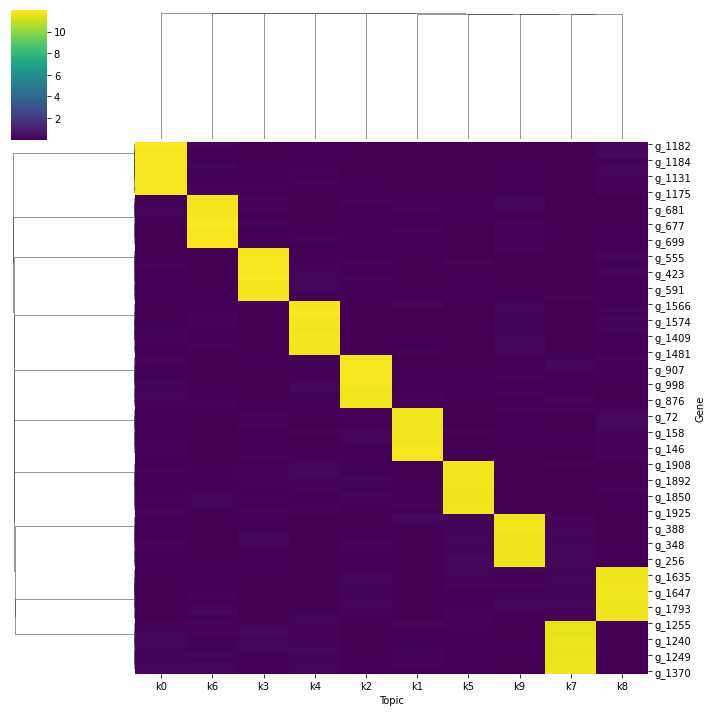

In [54]:
df_top = _topics_util.get_topic_top_genes(df_bbeta,top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')